<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/hello_graph_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Velickovic et al. (201) [Graph Attention Networks](https://arxiv.org/abs/1710.10903) and reimplementing the notebook provided in this nice tutorial: [Graph Attention in Pytorch-Geometric](https://www.youtube.com/watch?v=AWkPjrZshug) to get the hang of pytorch-geometric.

**Update**:

May need to read: https://arxiv.org/pdf/2206.06089 for connections between PGMs and

Stumbled across this: [When do we need GNNs for node classification?](https://link.springer.com/chapter/10.1007/978-3-031-53468-3_4) that may help answer some questions related to advantage of using a GNN vs a conventional MLP for classification (addressed at the very end of the notebook)

- Edge homophily is NOT necessarily a good measure for node classification tasks - on low homophily datasets, MLP may not outperform GNN and on high homophily, it may not underperform. (homophily definition???)

-

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
!pip install -q torch_geometric

In [ ]:
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import (GCNConv, GATConv)

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import glorot, zeros

from torch_geometric.datasets import Planetoid, KarateClub

from torch_geometric.transforms import (NormalizeFeatures, RandomNodeSplit)

from torch_geometric.data import Data
from torch_geometric import seed_everything

from sklearn.datasets import (make_blobs, make_circles)
from sklearn.manifold import TSNE

In [ ]:
random_seed=42
torch.manual_seed(1234567)
seed_everything(random_seed)
plt.style.use('dark_background')
accuracy_list=[]

X1, y1 = make_blobs(n_samples=200, centers=1, n_features=2, cluster_std=0.15, random_state=random_seed)
X1 = X1 - np.mean(X1, axis=0)

X2, y2 = make_circles(n_samples=(600, 200), noise=0.04, factor=0.5, random_state=random_seed)
y2 = y2 + 1
X2 = X2 * 3

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

plot_colors = cm.tab10.colors
y_colors = np.array(plot_colors)[y]

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

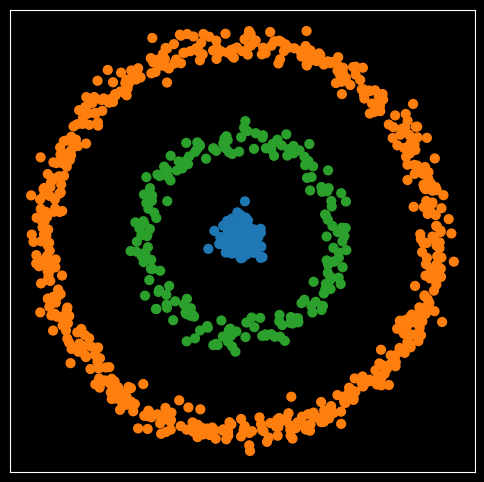

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_colors)

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)

In [ ]:
# An n by n matrix, where each element represents the similarity between a pair of samples
sigma = 1
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1)
A = np.exp(A / (2* sigma**2))
np.fill_diagonal(A, 0)

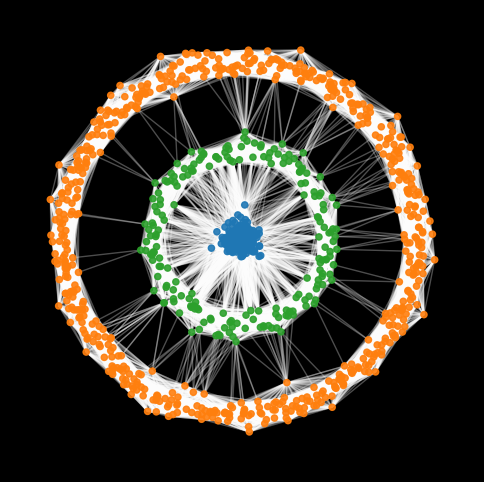

In [ ]:
# only keep edges with a value greater than 0.5
A1 = np.copy(A)
A1[A1 < 0.5] = 0
G = nx.from_numpy_array(A1)

plt.figure(figsize=(6,6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=X, node_size=20, node_color=y_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos=X, edge_color="white", alpha=0.3)
plt.show()

In [ ]:
A = A1
num_features = X.shape[1]
num_classes = np.unique(y).shape[0]

# create an edge list out of the adjacency matrix
edge_index, _ = from_scipy_sparse_matrix(sparse.csr_matrix(A))

In [ ]:
edge_index # array of which indices in A have an edge between them after removing edges with very small distance.

tensor([[  0,   0,   0,  ..., 999, 999, 999],
        [  1,   2,   3,  ..., 991, 995, 996]])

In [ ]:
# create a torch_geometric Data instance
data_synthetic = Data(x=torch.from_numpy(X.astype(np.float32)),
                      edge_index=edge_index,
                      y=torch.from_numpy(y))
# create train/val/test masks with 60%/10%/30%
split = RandomNodeSplit(num_val=0.1, num_test=0.3)
data_synthetic = split(data_synthetic)
data_synthetic

Data(x=[1000, 2], edge_index=[2, 96996], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])

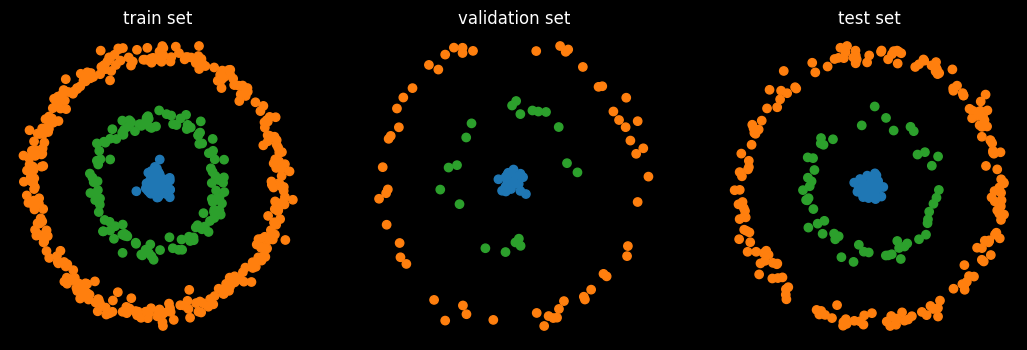

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
idxs = [data_synthetic.train_mask, data_synthetic.val_mask, data_synthetic.test_mask]
plt_label = ['train set', 'validation set', 'test set']
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].scatter(X[idx, 0], X[idx, 1], color=y_colors[idx])

plt.show()

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels*heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model1 = GAT(hidden_channels=16, heads=8)
print(model1)

GAT(
  (conv1): GATConv(2, 16, heads=8)
  (conv2): GATConv(128, 3, heads=1)
)


In [ ]:
count_parameters(model1)

1033

In [ ]:
def train(model, data, mask, GNN_flag):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      if GNN_flag:
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
      else:
        out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(model, data, mask, GNN_flag):
      model.eval()
      if GNN_flag:
        out = model(data.x, data.edge_index)
      else:
        out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model1, data_synthetic, data_synthetic.train_mask, GNN_flag=True)
    val_acc = test(model1, data_synthetic, data_synthetic.val_mask, GNN_flag=True)
    test_acc = test(model1, data_synthetic, data_synthetic.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'synthetic', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.1469, Val: 0.2900, Test: 0.2833
Epoch: 002, Loss: 1.0620, Val: 0.5700, Test: 0.6267
Epoch: 003, Loss: 1.0027, Val: 0.5700, Test: 0.6267
Epoch: 004, Loss: 0.9542, Val: 0.5700, Test: 0.6267
Epoch: 005, Loss: 0.9192, Val: 0.5700, Test: 0.6267
Epoch: 006, Loss: 0.8873, Val: 0.5700, Test: 0.6267
Epoch: 007, Loss: 0.8828, Val: 0.5700, Test: 0.6267
Epoch: 008, Loss: 0.8651, Val: 0.5700, Test: 0.6267
Epoch: 009, Loss: 0.8530, Val: 0.5700, Test: 0.6267
Epoch: 010, Loss: 0.8469, Val: 0.5700, Test: 0.6267
Epoch: 011, Loss: 0.8179, Val: 0.5700, Test: 0.6267
Epoch: 012, Loss: 0.7874, Val: 0.5700, Test: 0.6267
Epoch: 013, Loss: 0.7505, Val: 0.5700, Test: 0.6267
Epoch: 014, Loss: 0.7268, Val: 0.5700, Test: 0.6267
Epoch: 015, Loss: 0.6985, Val: 0.7400, Test: 0.7767
Epoch: 016, Loss: 0.6649, Val: 0.8000, Test: 0.8233
Epoch: 017, Loss: 0.6297, Val: 0.8000, Test: 0.8233
Epoch: 018, Loss: 0.5918, Val: 0.8000, Test: 0.8233
Epoch: 019, Loss: 0.5676, Val: 0.8000, Test: 0.8267
Epoch: 020, 

KeyboardInterrupt: 

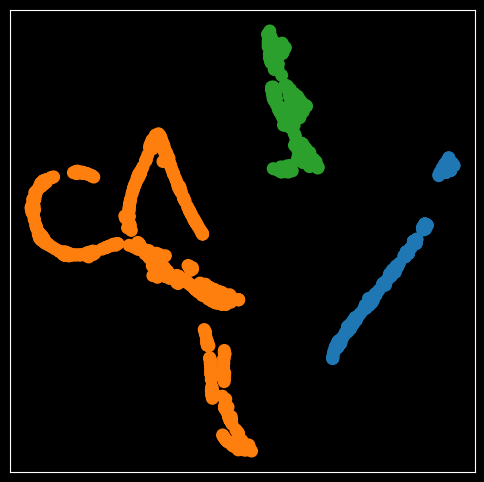

In [ ]:
model1.eval()
out = model1(data_synthetic.x, data_synthetic.edge_index)
visualize(out, y_colors)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [ ]:
model2 = MLP(hidden_channels=16)
print(model2)

MLP(
  (lin1): Linear(2, 16, bias=True)
  (lin2): Linear(16, 3, bias=True)
)


In [ ]:
count_parameters(model2)

99

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model2.parameters(), lr=0.1, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model2, data_synthetic, data_synthetic.train_mask, GNN_flag=False)
    val_acc = test(model2, data_synthetic, data_synthetic.val_mask, GNN_flag=False)
    test_acc = test(model2, data_synthetic, data_synthetic.test_mask, GNN_flag=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['MLP', 'synthetic', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.0766, Val: 0.5700, Test: 0.6267
Epoch: 002, Loss: 0.7845, Val: 0.5700, Test: 0.6267
Epoch: 003, Loss: 0.8041, Val: 0.5700, Test: 0.6267
Epoch: 004, Loss: 0.7732, Val: 0.5700, Test: 0.6267
Epoch: 005, Loss: 0.7598, Val: 0.5700, Test: 0.6267
Epoch: 006, Loss: 0.6915, Val: 0.5700, Test: 0.6267
Epoch: 007, Loss: 0.6417, Val: 0.8000, Test: 0.8233
Epoch: 008, Loss: 0.6013, Val: 0.8000, Test: 0.8233
Epoch: 009, Loss: 0.5737, Val: 0.8000, Test: 0.8233
Epoch: 010, Loss: 0.5673, Val: 0.8000, Test: 0.8233
Epoch: 011, Loss: 0.5447, Val: 0.8100, Test: 0.8267
Epoch: 012, Loss: 0.5187, Val: 0.8300, Test: 0.8367
Epoch: 013, Loss: 0.5201, Val: 0.8600, Test: 0.8467
Epoch: 014, Loss: 0.5102, Val: 0.9000, Test: 0.8733
Epoch: 015, Loss: 0.4842, Val: 0.9300, Test: 0.8967
Epoch: 016, Loss: 0.4641, Val: 0.9400, Test: 0.9300
Epoch: 017, Loss: 0.4430, Val: 0.9400, Test: 0.9633
Epoch: 018, Loss: 0.4463, Val: 0.9700, Test: 0.9767
Epoch: 019, Loss: 0.4208, Val: 0.9800, Test: 0.9600
Epoch: 020, 

In [ ]:
h = .05  # step size in the mesh
# create a mesh to plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plot_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()




# evaluate all the points in plot_mesh
model2.eval()
out = model2(plot_mesh)
pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = pred.reshape(xx.shape).detach().numpy()

In [ ]:
plot_mesh.shape

torch.Size([28900, 2])

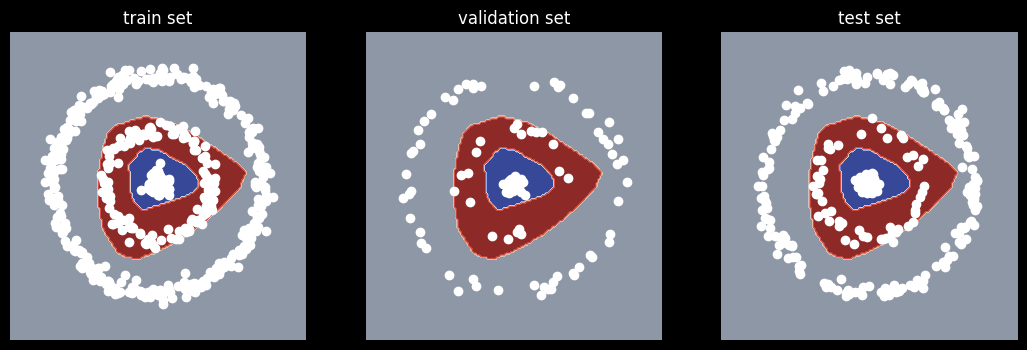

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].contourf(xx, yy, pred, cmap='coolwarm', alpha=0.7)
  axs[i].scatter(X[idx, 0], X[idx, 1], color='white')

plt.show()

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model3 = GAT(hidden_channels=16, heads=8)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model3, data_Cora, data_Cora.train_mask, GNN_flag=True)
    val_acc = test(model3, data_Cora, data_Cora.val_mask, GNN_flag=True)
    test_acc = test(model3, data_Cora, data_Cora.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9452, Val: 0.4000, Test: 0.4340
Epoch: 002, Loss: 1.9065, Val: 0.7540, Test: 0.7570
Epoch: 003, Loss: 1.8682, Val: 0.7500, Test: 0.7740
Epoch: 004, Loss: 1.8271, Val: 0.7700, Test: 0.7870
Epoch: 005, Loss: 1.7834, Val: 0.7780, Test: 0.7830
Epoch: 006, Loss: 1.7255, Val: 0.7720, Test: 0.7680
Epoch: 007, Loss: 1.6794, Val: 0.7660, Test: 0.7630
Epoch: 008, Loss: 1.6279, Val: 0.7700, Test: 0.7660
Epoch: 009, Loss: 1.5632, Val: 0.7800, Test: 0.7740
Epoch: 010, Loss: 1.4968, Val: 0.7900, Test: 0.7790
Epoch: 011, Loss: 1.4318, Val: 0.7900, Test: 0.7800
Epoch: 012, Loss: 1.3655, Val: 0.7940, Test: 0.7820
Epoch: 013, Loss: 1.2958, Val: 0.7940, Test: 0.7840
Epoch: 014, Loss: 1.2149, Val: 0.7900, Test: 0.7880
Epoch: 015, Loss: 1.1604, Val: 0.7900, Test: 0.7860
Epoch: 016, Loss: 1.0879, Val: 0.7860, Test: 0.7870
Epoch: 017, Loss: 1.0232, Val: 0.7840, Test: 0.7830
Epoch: 018, Loss: 0.9518, Val: 0.7920, Test: 0.7840
Epoch: 019, Loss: 0.9041, Val: 0.7900, Test: 0.7890
Epoch: 020, 

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model4 = MLP(hidden_channels=16)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.1, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(model4, data_Cora, data_Cora.train_mask, GNN_flag=False)
    val_acc = test(model4, data_Cora, data_Cora.val_mask, GNN_flag=False)
    test_acc = test(model4, data_Cora, data_Cora.test_mask, GNN_flag=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['MLP', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9577, Val: 0.3160, Test: 0.3190
Epoch: 002, Loss: 1.9386, Val: 0.2080, Test: 0.1920
Epoch: 003, Loss: 1.9032, Val: 0.2180, Test: 0.2230
Epoch: 004, Loss: 1.8411, Val: 0.2420, Test: 0.2400
Epoch: 005, Loss: 1.7794, Val: 0.2680, Test: 0.2780
Epoch: 006, Loss: 1.6740, Val: 0.3080, Test: 0.3210
Epoch: 007, Loss: 1.5521, Val: 0.3780, Test: 0.3470
Epoch: 008, Loss: 1.4530, Val: 0.4280, Test: 0.4050
Epoch: 009, Loss: 1.3721, Val: 0.4580, Test: 0.4620
Epoch: 010, Loss: 1.2393, Val: 0.4920, Test: 0.4680
Epoch: 011, Loss: 1.0767, Val: 0.4980, Test: 0.4830
Epoch: 012, Loss: 1.0068, Val: 0.4980, Test: 0.4770
Epoch: 013, Loss: 1.0028, Val: 0.4900, Test: 0.4710
Epoch: 014, Loss: 0.7901, Val: 0.5000, Test: 0.4850
Epoch: 015, Loss: 0.7184, Val: 0.5160, Test: 0.5130
Epoch: 016, Loss: 0.6936, Val: 0.5200, Test: 0.5300
Epoch: 017, Loss: 0.6314, Val: 0.5440, Test: 0.5450
Epoch: 018, Loss: 0.6596, Val: 0.5860, Test: 0.5570
Epoch: 019, Loss: 0.5676, Val: 0.5880, Test: 0.5610
Epoch: 020, 

In [ ]:
# df = pd.DataFrame(accuracy_list, columns=('Method', 'Dataset', 'Accuracy'))
# sns.barplot(df,x='Dataset', y='Accuracy', hue='Method', palette="muted")
# plt.show()

In [ ]:
# # An n by n matrix, where each element represents the similarity between a pair of samples
# sigma = 1
# APM = -1 * np.square(plot_mesh[:, None, :] - plot_mesh[None, :, :]).sum(axis=-1)
# APM = np.exp(APM / (2* sigma**2))
# np.fill_diagonal(APM, 0)

In [ ]:
# # only keep edges with a value greater than 0.5
# A1PM = np.copy(APM)
# A1PM[A1PM < 0.5] = 0
# GPM = nx.from_numpy_array(A1PM)

# plt.figure(figsize=(6,6))
# plt.axis('off')
# nx.draw_networkx_nodes(GPM, pos=plot_mesh, node_size=20, node_color=y_colors, alpha=0.9)
# nx.draw_networkx_edges(GPM, pos=plot_mesh, edge_color="white", alpha=0.3)
# plt.show()

In [ ]:
# A = A1
# num_features = X.shape[1]
# num_classes = np.unique(y).shape[0]

# # create an edge list out of the adjacency matrix
# edge_index, _ = from_scipy_sparse_matrix(sparse.csr_matrix(A))

In [ ]:
data_Cora.x.shape

torch.Size([2708, 1433])

In [ ]:
data_Cora.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [ ]:
plot_colors = cm.tab10.colors
y_colors2 = np.array(plot_colors)[data_Cora.y.unique().detach().numpy()]

In [ ]:
y_colors2.shape

(7, 3)

In [ ]:
y_colors.shape

(1000, 3)

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

In [ ]:
model3.eval()
out = model3(data_Cora.x, data_Cora.edge_index)

out.shape
# visualize(out, y_colors2)

torch.Size([2708, 7])

In [ ]:
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

In [ ]:
z.shape

(2708, 2)

In [ ]:
labels = data_Cora.y.detach().numpy()
labels.shape

(2708,)

In [ ]:
colormap2 = np.array(['red', 'lightseagreen', 'orange', 'goldenrod', 'cyan', 'blue', 'purple'])

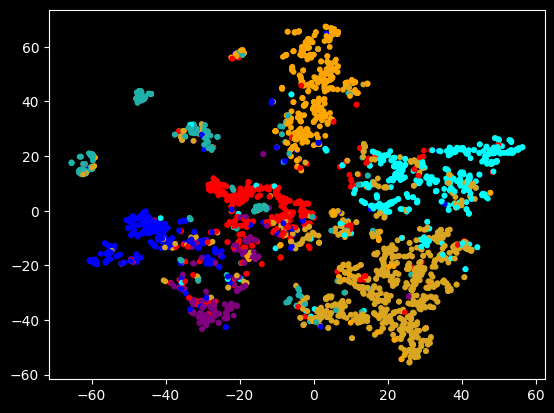

In [ ]:
plt.scatter(z[:, 0], z[:, 1], s=10, c=colormap2[labels])